In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [2]:
class LogicLinear(nn.Module):
    def __init__(self, in_, out_) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, out_),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [3]:
mnist_fashion = fetch_openml("Fashion-MNIST", as_frame=False)


c:\Users\KDP-25\.conda\envs\Torch_PY38\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist_fashion.data, mnist_fashion.target
X.shape, y.shape


((70000, 784), (70000,))

In [5]:
y = y.astype(np.int64)


In [6]:
feature_train_ori = X[:60000]
target_train_ori = y[:60000]
feature_test = X[60000:]
target_test = y[60000:]

feature_train_ori.shape, target_train_ori.shape, feature_test.shape, target_test.shape


((60000, 784), (60000,), (10000, 784), (10000,))

In [7]:
feature_train, feature_val, target_train, target_val = train_test_split(
    feature_train_ori,
    target_train_ori,
    test_size=10000,
    random_state=42,
    stratify=target_train_ori,
)

feature_train.shape, target_train.shape, feature_val.shape, target_val.shape


((50000, 784), (50000,), (10000, 784), (10000,))

In [8]:
X_train = torch.FloatTensor(feature_train) / 255.0
X_val = torch.FloatTensor(feature_val) / 255.0
X_test = torch.FloatTensor(feature_test) / 255.0

y_train = torch.LongTensor(target_train)
y_val = torch.LongTensor(target_val)
y_test = torch.LongTensor(target_test)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [9]:
in_ = X_train.shape[1]
out_ = len(torch.unique(y_train))

model = LogicLinear(in_, out_)
optimizer = optim.Adam(model.parameters())

model, optimizer


(LogicLinear(
   (layers): Sequential(
     (0): Linear(in_features=784, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=10, bias=True)
   )
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [10]:
lossList = [[], []]
accuracyList = [[], []]
nb_epochs = 1000
count = 0
for epoch in range(nb_epochs + 1):
    prediction = model(X_train)
    train_loss = F.cross_entropy(prediction, y_train)
    lossList[0].append(train_loss.item())

    with torch.no_grad():
        val_prediction = model(X_val)
        val_loss = F.cross_entropy(val_prediction, y_val)
        lossList[1].append(val_loss.item())
        assert val_loss.requires_grad == False

    diff = (val_loss - train_loss).abs()

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    train_accuracy = (
        (y_train == F.softmax(prediction, dim=1).argmax(dim=1)).sum()
    ) / y_train.shape[0]
    accuracyList[0].append(train_accuracy.item())

    val_accuracy = (
        y_val == F.softmax(val_prediction, dim=1).argmax(dim=1)
    ).sum() / y_val.shape[0]
    accuracyList[1].append(val_accuracy.item())

    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:4d}/{nb_epochs} Train_loss: {train_loss.item():.4f} Val_loss: {val_loss.item():.4f} Diff: {diff.item():.6f}    Train_accuracy: {train_accuracy:.4f} Val_accuracy: {val_accuracy:.4f}"
        )

    if diff.item() >= 0.03:
        count += 1
    else:
        count = 0

    if count >= 5:
        print(
            f"Epoch {epoch:4d}/{nb_epochs} Train_loss: {train_loss.item():.4f} Val_loss: {val_loss.item():.4f} Diff: {diff.item():.6f}    Train_accuracy: {train_accuracy:.4f} Val_accuracy: {val_accuracy:.4f}"
        )
        break


Epoch    0/1000 Train_loss: 2.3000 Val_loss: 2.3003 Diff: 0.000288    Train_accuracy: 0.1000 Val_accuracy: 0.1002
Epoch   10/1000 Train_loss: 1.4126 Val_loss: 1.4160 Diff: 0.003440    Train_accuracy: 0.6306 Val_accuracy: 0.6335
Epoch   20/1000 Train_loss: 0.8417 Val_loss: 0.8376 Diff: 0.004103    Train_accuracy: 0.6981 Val_accuracy: 0.7028
Epoch   30/1000 Train_loss: 0.6698 Val_loss: 0.6582 Diff: 0.011603    Train_accuracy: 0.7618 Val_accuracy: 0.7694
Epoch   40/1000 Train_loss: 0.5793 Val_loss: 0.5674 Diff: 0.011913    Train_accuracy: 0.7982 Val_accuracy: 0.7999
Epoch   50/1000 Train_loss: 0.5285 Val_loss: 0.5154 Diff: 0.013148    Train_accuracy: 0.8177 Val_accuracy: 0.8196
Epoch   60/1000 Train_loss: 0.4925 Val_loss: 0.4787 Diff: 0.013792    Train_accuracy: 0.8296 Val_accuracy: 0.8316
Epoch   70/1000 Train_loss: 0.4686 Val_loss: 0.4562 Diff: 0.012381    Train_accuracy: 0.8372 Val_accuracy: 0.8382
Epoch   80/1000 Train_loss: 0.4484 Val_loss: 0.4369 Diff: 0.011588    Train_accuracy: 0.

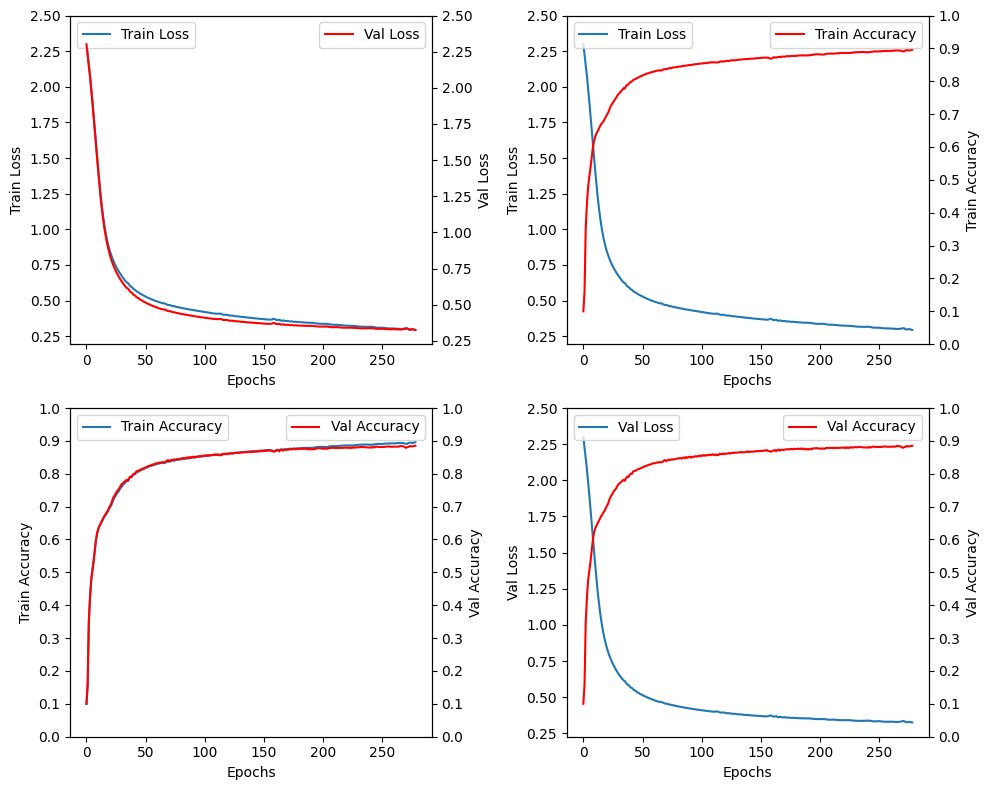

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(lossList[0], label="Train Loss")
axs[0, 0].legend(loc="upper left")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Train Loss")
axs[0, 0].set_yticks(np.arange(0.25, 2.51, 0.25))
axs1 = axs[0, 0].twinx()
axs1.plot(lossList[1], label="Val Loss", color="red")
axs1.legend(loc="upper right")
axs1.set_ylabel("Val Loss")
axs1.set_yticks(np.arange(0.25, 2.51, 0.25))

axs[0, 1].plot(lossList[0], label="Train Loss")
axs[0, 1].legend(loc="upper left")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Train Loss")
axs[0, 1].set_yticks(np.arange(0.25, 2.51, 0.25))
axs2 = axs[0, 1].twinx()
axs2.plot(accuracyList[0], label="Train Accuracy", color="red")
axs2.legend(loc="upper right")
axs2.set_ylabel("Train Accuracy")
axs2.set_yticks(np.arange(0, 1.1, 0.1))


axs[1, 0].plot(accuracyList[0], label="Train Accuracy")
axs[1, 0].legend(loc="upper left")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Train Accuracy")
axs[1, 0].set_yticks(np.arange(0, 1.1, 0.1))
axs3 = axs[1, 0].twinx()
axs3.plot(accuracyList[1], label="Val Accuracy", color="red")
axs3.legend(loc="upper right")
axs3.set_ylabel("Val Accuracy")
axs3.set_yticks(np.arange(0, 1.1, 0.1))


axs[1, 1].plot(lossList[1], label="Val Loss")
axs[1, 1].legend(loc="upper left")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Val Loss")
axs[1, 1].set_yticks(np.arange(0.25, 2.51, 0.25))
axs4 = axs[1, 1].twinx()
axs4.plot(accuracyList[1], label="Val Accuracy", color="red")
axs4.legend(loc="upper right")
axs4.set_ylabel("Val Accuracy")
axs4.set_yticks(np.arange(0, 1.1, 0.1))
plt.tight_layout()
plt.show()


In [12]:
test_accuracy = (
    (y_test == F.softmax(model(X_test), dim=1).argmax(dim=1)).sum() / X_test.size(0)
).item()
print(f"Test Accuracy : {test_accuracy:.4f}")


Test Accuracy : 0.8672
